# Machine learning at CoDaS-HEP 2024, lesson 1 part 2

<br><br><br><br><br>

## Reminders

As a reminder, a (simple, feed-forward, 4-layer) neural network looks like this:

<img src="../img/artificial-neural-network-layers-2.svg" width="700">

<br><br><br><br><br>

Which is to say, like this:

$$
y_i =
f\left(a_{i,j}^{\mbox{\scriptsize L3-L4}} \cdot
f\left(a_{i,j}^{\mbox{\scriptsize L2-L3}} \cdot
f\left(a_{i,j}^{\mbox{\scriptsize L1-L2}} \cdot x_j + b_i^{\mbox{\scriptsize L1-L2}}\right)
+ b_i^{\mbox{\scriptsize L2-L3}}\right)
+ b_i^{\mbox{\scriptsize L3-L4}}\right)
$$

<br><br><br><br><br>

In code, that means:

In [1]:
import numpy as np

In [2]:
# take 8-dimensional input layer 1 to 7-dimensional hidden layer 2
a_L1_L2 = np.random.normal(0, 1, (7, 8))
b_L1_L2 = np.random.normal(0, 1, (7,))

# take 7-dimensional hidden layer 2 to 9-dimensional hidden layer 3
a_L2_L3 = np.random.normal(0, 1, (9, 7))
b_L2_L3 = np.random.normal(0, 1, (9,))

# take 9-dimensional hidden layer 3 to 6-dimensional output layer 4
a_L3_L4 = np.random.normal(0, 1, (6, 9))
b_L3_L4 = np.random.normal(0, 1, (6,))

def relu(x):
    return np.maximum(0, x)

def model(x):
    layer1 = x
    layer2 = relu(a_L1_L2 @ layer1 + b_L1_L2)
    layer3 = relu(a_L2_L3 @ layer2 + b_L2_L3)
    layer4 = relu(a_L3_L4 @ layer3 + b_L3_L4)
    y = layer4
    return y

Here's the model's output for a sample input:

In [3]:
x = np.random.normal(0, 1, (8,))

model(x)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       6.94947463])

<br><br><br><br><br>

Given a large dataset of `x` vectors, an equally large set of expected `y` vectors, and a minimizer, we could train the model by optimizing these parameters:

In [4]:
a_L1_L2

array([[-0.61939031, -0.26817003, -2.5699332 ,  0.72122381,  0.57690105,
        -0.3990577 , -0.88149949, -1.24038066],
       [ 0.61333929, -1.65363106,  1.1048434 ,  0.09068926, -0.03121668,
        -0.69767834,  0.31221768,  0.86916096],
       [-0.59313061,  0.03537902,  0.77244024, -1.17312796,  1.4852837 ,
         0.71128194, -2.13790879, -1.08230326],
       [ 0.23523277,  0.22486625,  0.5933877 , -0.58226267, -0.71364578,
         0.47785871,  0.44411832, -1.96896781],
       [-1.27444881, -1.11846584, -1.01153163, -0.17111053,  0.9019678 ,
        -0.60841783, -0.54168892, -1.54515377],
       [ 1.33866411, -0.45262403,  0.75276824, -1.08662132,  0.0845939 ,
         0.679121  ,  0.30559478, -0.88533055],
       [ 0.61122869, -1.30651499, -1.42145953, -0.81161179,  0.10260824,
         0.56157157,  0.00831153, -0.87808046]])

In [5]:
b_L1_L2

array([-0.79827568, -0.77327267,  1.39538112,  0.33725184, -0.00603216,
        0.5791685 ,  0.89475988])

In [6]:
a_L2_L3

array([[-0.84974658,  0.44567837, -0.49015375,  0.23967948, -1.06738733,
        -1.65905027, -0.46073657],
       [-0.1267414 ,  0.81433101, -0.32576001,  0.04221631,  0.68905821,
         0.31967231, -0.30768247],
       [-1.09584483,  0.0126168 ,  0.32967037,  0.64002468,  0.20281222,
        -1.24452847, -0.07649658],
       [ 0.40368018, -0.28255721,  1.82606618,  0.41921754,  0.61929682,
         1.10813563,  0.80682207],
       [ 0.52271314, -1.38666257,  0.48415797,  0.716695  , -0.03145548,
         0.95801425, -1.09766022],
       [ 0.01132805, -1.07634989, -0.58322941,  1.01665155, -0.81784159,
         1.71021758,  1.92972472],
       [ 2.53007057,  1.80365251, -1.04629283, -0.94841795,  1.13542071,
        -1.21283234, -1.71542722],
       [ 0.38179733, -0.4002855 , -0.2058657 ,  0.25163443, -0.36034179,
         0.84768524,  0.6160505 ],
       [ 0.22318632, -0.63805305, -1.85008342,  0.41038157, -1.07911522,
        -0.20699457, -0.77564639]])

In [7]:
b_L2_L3

array([ 0.40663678,  0.05927359, -0.13080534, -1.07918374, -1.52189874,
       -0.85069273, -0.24338771,  1.32849934,  1.13702672])

In [8]:
a_L3_L4

array([[-0.5173439 ,  0.27435261,  0.54541899,  0.39885109,  0.0341021 ,
        -0.915353  ,  0.43242198, -1.13348509, -1.76491851],
       [-0.18015463,  1.93065554,  0.00461451,  0.31532293, -0.76040723,
        -1.4476316 ,  0.34755725,  0.28938838, -0.24885187],
       [ 2.26262373, -0.74257415,  0.67200946,  0.9348691 , -2.11426077,
        -1.60469245, -0.43499491,  1.35687304,  0.55803157],
       [-0.04390153, -0.63014777,  1.22445008,  0.18747987, -0.76667051,
        -1.29670197,  1.55064763, -1.97802388,  1.40495576],
       [-0.499301  ,  0.86546508,  0.19774019, -0.35608598,  0.80727784,
        -0.09981527, -0.869896  , -1.00088313, -0.84666013],
       [-0.2036228 ,  0.65940605, -1.17649671,  1.88420466, -0.98964637,
        -0.68928046, -0.29490981, -0.65122812, -1.13491969]])

In [9]:
b_L3_L4

array([ 0.17523983, -1.3979932 ,  0.4395739 ,  1.1386153 ,  0.1307743 ,
        1.58853467])

such that `model(x)` comes as close as possible to `y`.

Then we could use `model(x_new)` to predict new $y$ values for `x_new`, and the predictions would have (roughly) the same correlations as the training dataset.

<br><br><br><br><br>

HEP has a favorite minimizer: MINUIT.

Introduced in 1972 by Fred James, MINUIT computes numerical second derivatives of the function, attempts to jump to the minimum, and then recomputes.

<img src="../img/minuit-1975.png" width="1000">

<br><br><br><br><br>

It doesn't scale well with a large number of parameters to optimize, and we would have

In [10]:
a_L1_L2.size + b_L1_L2.size + a_L2_L3.size + b_L2_L3.size + a_L3_L4.size + b_L3_L4.size

195

parameters to optimize in this simple example.

Nevertheless, we'll use MINUIT in some early examples, through the excellent iminuit package.

<img src="https://raw.githubusercontent.com/scikit-hep/iminuit/develop/doc/_static/iminuit_logo.svg" width="300">

In [11]:
import iminuit

<br><br><br><br><br>

As another simplification, note that we don't have to maintain the distinction between matrices of parameters $a_{i,j}$ and vectors of parameters $b_i$:

$$
\left(\begin{array}{c c c c}
a_{1,1} & a_{1,2} & \ldots & a_{1,10} \\
a_{2,1} & a_{2,2} & \ldots & a_{2,10} \\
a_{3,1} & a_{3,2} & \ldots & a_{3,10} \\
a_{4,1} & a_{4,2} & \ldots & a_{4,10} \\
a_{5,1} & a_{5,2} & \ldots & a_{5,10} \\
\end{array}\right) \cdot \left(\begin{array}{c}
x_1 \\
x_2 \\
\vdots \\
x_{10} \\
\end{array}\right) + \left(\begin{array}{c}
b_1 \\
b_2 \\
b_3 \\
b_4 \\
b_5 \\
\end{array}\right)
$$

is the same as

$$
\left(\begin{array}{c c c c c}
a_{1,1} & a_{1,2} & \ldots & a_{1,10} & b_1 \\
a_{2,1} & a_{2,2} & \ldots & a_{2,10} & b_2 \\
a_{3,1} & a_{3,2} & \ldots & a_{3,10} & b_3 \\
a_{4,1} & a_{4,2} & \ldots & a_{4,10} & b_4 \\
a_{5,1} & a_{5,2} & \ldots & a_{5,10} & b_5 \\
\end{array}\right) \cdot \left(\begin{array}{c}
x_1 \\
x_2 \\
\vdots \\
x_{10} \\
1 \\
\end{array}\right)
$$

We can absorb our $b_i$ vectors into a bigger matrix $A_{i,j}$ with the understanding that we concatenate a $1$ at the end of the $x_j$ vector.

<br><br><br><br><br>

## What's so special about this linear-nonlinear sandwich?

The goal of curve-fitting is to _approximate a function_ from noisy samples.

Neural networks are special because they are exceptionally good at approximating functions, a fact that is formally expressed as the [universal approximation theorem(s)](https://en.wikipedia.org/wiki/Universal_approximation_theorem).

<br><br><br><br><br>

As a physicist, I've approximated a few functions in my time. What's "exceptionally good" about this method?

<br><br><br><br><br>

### Demonstrate with a sample problem

Suppose $x$ and $y$ are related as

$$ y = \left\{\begin{array}{l l}
\sin(22 x) & \mbox{if } |x - 0.43| < 0.15 \\
-1 + 3.5 x - 2 x^2 & \mbox{otherwise} \\
\end{array}\right. $$

with small errors.

In [12]:
def truth(x):
    return np.where(abs(x - 0.43) < 0.15, np.sin(22*x), -1 + 3.5*x - 2*x**2)

x = np.random.uniform(0, 1, 1000)
y = truth(x) + np.random.normal(0, 0.03, 1000)

<br><br>

In [13]:
import matplotlib.pyplot as plt

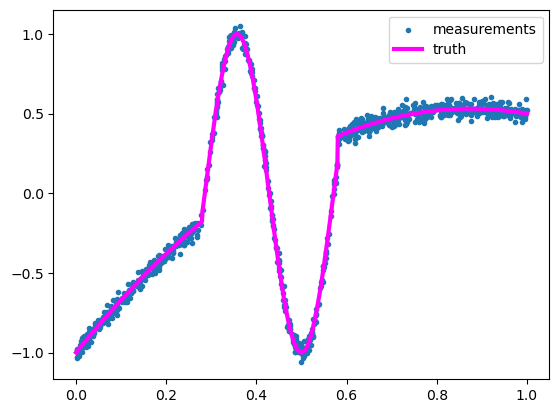

In [14]:
fig, ax = plt.subplots()

ax.scatter(x, y, marker=".")
ax.plot(np.linspace(0, 1, 1000), truth(np.linspace(0, 1, 1000)), color="magenta", linewidth=3)

ax.legend(["measurements", "truth"])

None

<br><br><br><br><br>

### Attempt 1: a linear fit

A linear fit is terrible because the curve isn't close to being linear.

In [15]:
# a linear fit can be computed analytically, which is nice
sum1 = len(x)
sumx = np.sum(x)
sumy = np.sum(y)
sumxx = np.sum(x**2)
sumxy = np.sum(x * y)
delta = (sum1 * sumxx) - (sumx * sumx)

slope = ((sum1 * sumxy) - (sumx * sumy)) / delta
intercept = ((sumxx * sumy) - (sumx * sumxy)) / delta

model_x = np.linspace(0, 1, 1000)
model_y = slope * model_x + intercept

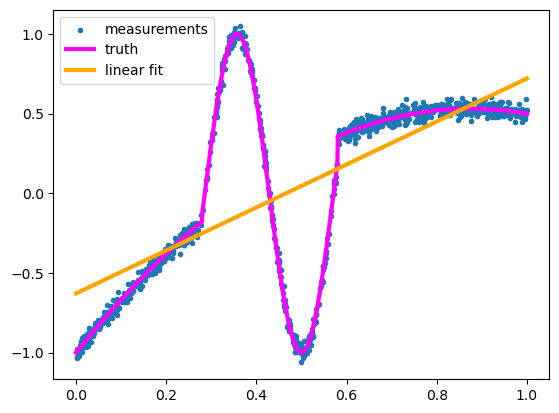

In [16]:
fig, ax = plt.subplots()

ax.scatter(x, y, marker=".")
ax.plot(np.linspace(0, 1, 1000), truth(np.linspace(0, 1, 1000)), color="magenta", linewidth=3)
ax.plot(model_x, model_y, color="orange", linewidth=3)

ax.legend(["measurements", "truth", "linear fit"])

None

<br><br><br><br><br>

### Attempt 2: a theory-driven ansatz

A physicist's usual strategy is to find the underlying theory, even if some parameters are unknown (an "ansatz").

Suppose we _just know_ that the functional form is

$$ y = \left\{\begin{array}{l l}
\sin(C x) & \mbox{if } |x - A| < B \\
D + E x + F x^2 & \mbox{otherwise} \\
\end{array}\right. $$

for some $A$, $B$, $C$, $D$, $E$, $F$.

In [17]:
def ansatz(x, A, B, C, D, E, F):
    return np.where(abs(x - A) < B, np.sin(C*x), D + E*x + F*x**2)

In [18]:
from iminuit.cost import LeastSquares

In [19]:
# define a cost function that is minimized when the parameterized ansatz is equal to truth
least_squares = LeastSquares(x, y, 0.03, ansatz)

# set initial parameter values
minimizer = iminuit.Minuit(least_squares, A=0.43, B=0.15, C=22, D=-1, E=3.5, F=-2)
minimizer.migrad()

model_x = np.linspace(0, 1, 1000)
model_y = ansatz(model_x, **{p.name: p.value for p in minimizer.params})

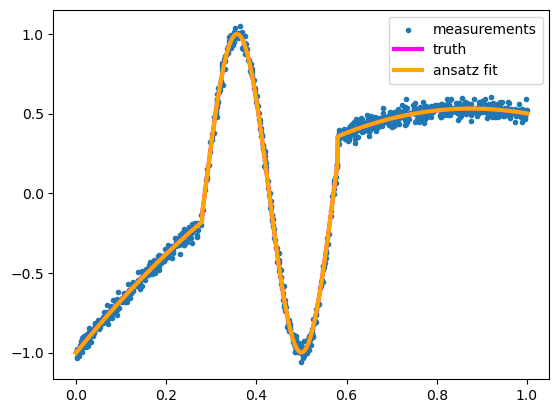

In [20]:
fig, ax = plt.subplots()

ax.scatter(x, y, marker=".")
ax.plot(np.linspace(0, 1, 1000), truth(np.linspace(0, 1, 1000)), color="magenta", linewidth=3)
ax.plot(model_x, model_y, color="orange", linewidth=3)

ax.legend(["measurements", "truth", "ansatz fit"])

None

<br><br>

It's a great fit, but

* what if we don't know the functional form? or if it's super-complicated, like human behavior?
* the fit depends sensitively on the initial parameters and step size (try starting any of the parameters at the wrong value).

<br><br><br><br><br>

### Attempt 3: orthonormal basis functions

As physicists, we would approach a _generic_ unknown function with a [Taylor series](https://en.wikipedia.org/wiki/Taylor_series), a [Fourier series](https://en.wikipedia.org/wiki/Fourier_series), or other sum of orthonormal basis functions ([Jacobi](https://en.wikipedia.org/wiki/Jacobi_polynomials), [Laguerre](https://en.wikipedia.org/wiki/Laguerre_polynomials), [Hermite](https://en.wikipedia.org/wiki/Hermite_polynomials), [Chebyshev](https://en.wikipedia.org/wiki/Chebyshev_polynomials), ...).

In [21]:
NUMBER_OF_POLYNOMIAL_TERMS = 15

# NumPy has a function for polynomial fits
# (which is analytic because it can be transformed into a linear fit)
coefficients = np.polyfit(x, y, NUMBER_OF_POLYNOMIAL_TERMS - 1)[::-1]

model_x = np.linspace(0, 1, 1000)
model_y = sum(c * model_x**i for i, c in enumerate(coefficients))

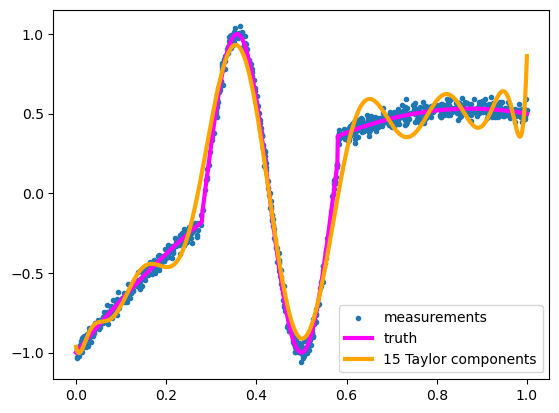

In [22]:
fig, ax = plt.subplots()

ax.scatter(x, y, marker=".")
ax.plot(np.linspace(0, 1, 1000), truth(np.linspace(0, 1, 1000)), color="magenta", linewidth=3)
ax.plot(model_x, model_y, color="orange", linewidth=3)

ax.legend(["measurements", "truth", f"{len(coefficients)} Taylor components"])

None

<br><br><br><br><br>

In [23]:
NUMBER_OF_COS_TERMS = 7
NUMBER_OF_SIN_TERMS = 7

# NumPy's FFT doesn't apply because the data aren't uniformly spaced, but we can compute a Fourier series with integrals
sort_index = np.argsort(x)
x_sorted = x[sort_index]
y_sorted = y[sort_index]

constant_term = np.trapz(y_sorted, x_sorted)
cos_terms = [2*np.trapz(y_sorted * np.cos(2*np.pi * (i + 1) * x_sorted), x_sorted) for i in range(NUMBER_OF_COS_TERMS)]
sin_terms = [2*np.trapz(y_sorted * np.sin(2*np.pi * (i + 1) * x_sorted), x_sorted) for i in range(NUMBER_OF_SIN_TERMS)]

model_x = np.linspace(0, 1, 1000)
model_y = (
    constant_term +
    sum(coefficient * np.cos(2*np.pi * (i + 1) * model_x) for i, coefficient in enumerate(cos_terms)) +
    sum(coefficient * np.sin(2*np.pi * (i + 1) * model_x) for i, coefficient in enumerate(sin_terms))
)

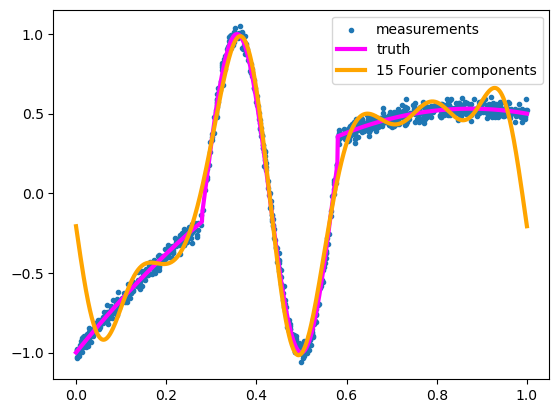

In [24]:
fig, ax = plt.subplots()

ax.scatter(x, y, marker=".")
ax.plot(np.linspace(0, 1, 1000), truth(np.linspace(0, 1, 1000)), color="magenta", linewidth=3)
ax.plot(model_x, model_y, color="orange", linewidth=3)

ax.legend(["measurements", "truth", f"{1 + len(cos_terms) + len(sin_terms)} Fourier components"])

None

<br><br>

The problem is that the true function is neither polynomial nor sinusoidal.

Convergence is slow and has artifacts.

<br><br><br><br><br>

### Attempt 4: adaptive basis functions

The classical methods (Taylor, Fourier, etc.) have one thing in common: they all use a fixed set of functions $\psi_i$ for discrete $i$:

$$ f(x) = \sum_i^N c_i \psi_i(x) $$

All that is allowed to vary in the fit are the coefficients $c_i$ in front of each function.

<br><br><br><br><br>

Suppose, instead, we had a set of functions that could also _change shape_:

$$ f(x) = \sum_i^N c_i \psi(x; \alpha_i, \beta_i) $$

For instance, the functions are sigmoids whose center $\alpha$ and width $\beta$ are adjustable:

$$ \psi(x; \alpha, \beta) = \frac{1}{1 + \exp\big((x - \alpha)/\beta\big)} $$

In [25]:
def sigmoid_component(x, center, width):
    # ignore NumPy errors when Minuit explores extreme values
    with np.errstate(over="ignore", divide="ignore"):
        return 1 / (1 + np.exp((x - center) / width))

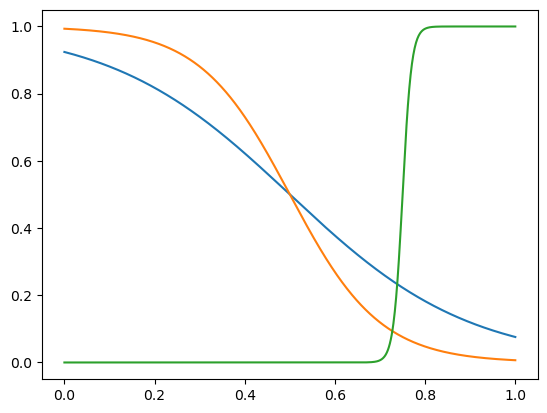

In [26]:
fig, ax = plt.subplots()

model_x = np.linspace(0, 1, 1000)

ax.plot(model_x, sigmoid_component(model_x, 0.5, 0.2))
ax.plot(model_x, sigmoid_component(model_x, 0.5, 0.1))
ax.plot(model_x, sigmoid_component(model_x, 0.75, -0.01))

None

<br><br><br><br><br>

In [27]:
NUMBER_OF_SIGMOIDS = 5

def sigmoid_sum(x, parameters):
    out = np.zeros_like(x)
    for coefficient, center, width in parameters.reshape(-1, 3):
        out += coefficient * sigmoid_component(x, center, width)
    return out

# using Minuit again
least_squares = LeastSquares(x, y, 0.03, sigmoid_sum)

# do best of 15 optimizations because this space has a lot more local minima
best_minimizer = None
for iteration in range(15):

    initial_parameters = np.zeros(5 * 3)
    initial_parameters[0::3] = np.random.normal(0, 1, NUMBER_OF_SIGMOIDS)    # coefficient terms
    initial_parameters[1::3] = np.random.uniform(0, 1, NUMBER_OF_SIGMOIDS)   # center parameters (alpha)
    initial_parameters[2::3] = np.random.normal(0, 0.1, NUMBER_OF_SIGMOIDS)  # width parameters (beta)

    minimizer = iminuit.Minuit(least_squares, initial_parameters)
    minimizer.migrad()

    if best_minimizer is None or minimizer.fval < best_minimizer.fval:
        best_minimizer = minimizer

model_x = np.linspace(0, 1, 1000)
model_y = sigmoid_sum(model_x, np.array(best_minimizer.values))

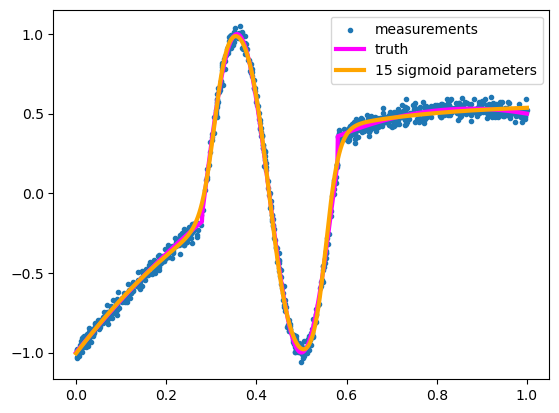

In [28]:
fig, ax = plt.subplots()

ax.scatter(x, y, marker=".")
ax.plot(np.linspace(0, 1, 1000), truth(np.linspace(0, 1, 1000)), color="magenta", linewidth=3)
ax.plot(model_x, model_y, color="orange", linewidth=3)

ax.legend(["measurements", "truth", f"{len(minimizer.parameters)} sigmoid parameters"])

None

<br><br><br><br><br>

The fitter doesn't need very many sigmoids because it can position them and stretch them arbitrarily.

They can stack to build piecewise shapes.

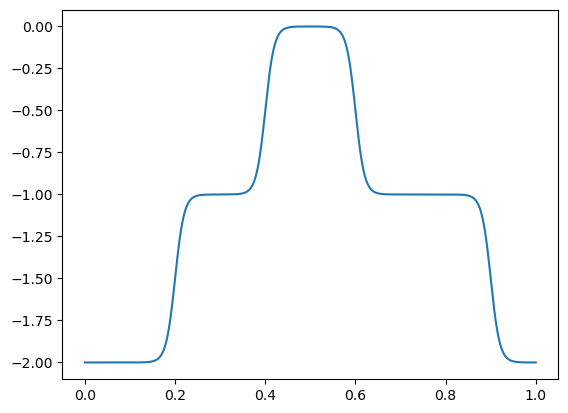

In [29]:
fig, ax = plt.subplots()

model_x = np.linspace(0, 1, 1000)

wide_plateau_left = sigmoid_component(model_x, 0.2, 0.01)
wide_plateau_right = sigmoid_component(model_x, 0.9, -0.01)

narrow_peak_left = sigmoid_component(model_x, 0.4, 0.01)
narrow_peak_right = sigmoid_component(model_x, 0.6, -0.01)

ax.plot(model_x, -wide_plateau_left - wide_plateau_right - narrow_peak_left - narrow_peak_right)

None

<br><br><br><br><br>

### Adaptive basis functions _are_ a neural network layer

Instead of a parameterized sigmoid,

$$ \psi(x; \alpha, \beta) = \frac{1}{1 + \exp\big((x - \alpha)/\beta\big)} $$

consider applying a linear transformation to the input of a sigmoid:

$$
x^{\mbox{\scriptsize layer 2}} = \frac{x^{\mbox{\scriptsize layer 1}} - \alpha}{\beta}
\mbox{\hspace{1 cm}and\hspace{1 cm}}
f(x^{\mbox{\scriptsize layer 2}}) = \frac{1}{1 + \exp\big( x^{\mbox{\scriptsize layer 2}} \big)}
$$

<br><br><br><br><br>

5 independently scaled sigmoids are a single hidden layer with 5 nodes:

$$
y =
c_i^{\mbox{\scriptsize L2--L3}} \cdot
f\left(\frac{x - \alpha_i^{\mbox{\scriptsize L1-L2}}}{\beta_i^{\mbox{\scriptsize L1-L2}}}\right)
$$

The 5 $\alpha$ and 5 $\beta$ parameters are the linear transformation from the input layer 1 to the hidden layer 2, the sigmoid $f$ is the activation function, and the coefficients in front of each sigmoid $c$ are the linear transformation from layer 2 to the output layer 3.

<img src="../img/artificial-neural-network-layers-3.svg" width="700">

<br><br><br><br><br>

To further demonstrate this, let's use a neural network implementation from Scikit-Learn to fit the same data.

In [30]:
import sklearn.neural_network

In [31]:
# do best of 15 optimizations because this space has a lot more local minima
best_neural_network = None
for iteration in range(15):

    # Scikit-Learn's MLPRegressor uses ordinary least squares as a loss function
    # the "logistic" activation function is our sigmoid
    neural_network = sklearn.neural_network.MLPRegressor(
        activation="logistic", hidden_layer_sizes=(5,),
        solver="lbfgs", max_iter=10000, alpha=0,
    )
    
    neural_network.fit(x[:, np.newaxis], y)

    if best_neural_network is None or neural_network.loss_ < best_neural_network.loss_:
        best_neural_network = neural_network

model_x = np.linspace(0, 1, 1000)
model_y = best_neural_network.predict(model_x[:, np.newaxis])

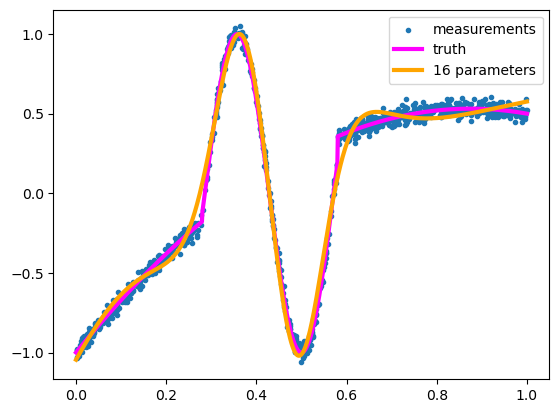

In [32]:
fig, ax = plt.subplots()

ax.scatter(x, y, marker=".")
ax.plot(np.linspace(0, 1, 1000), truth(np.linspace(0, 1, 1000)), color="magenta", linewidth=3)
ax.plot(model_x, model_y, color="orange", linewidth=3)

num_params = sum(x.size for x in neural_network.coefs_) + sum(x.size for x in neural_network.intercepts_)
ax.legend(["measurements", "truth", f"{num_params} parameters"])

None

(A real neural network has one more bias term per output variable than our analogy, so 16 parameters, not 15.)

<br><br><br><br><br>

Thus, a neural network with a hidden layer is a function approximator like Taylor and Fourier series, but with a special property: the basis functions are adaptive.

<br><br>

One consequence of this is that the basis functions are not orthogonal, like Taylor and Fourier series.

* Since Taylor and Fourier basis functions are orthogonal, they can be determined independently.
* Since a neural network's adaptive basis functions are not, they _must_ be determined by a combined fit.

<br><br>

In fact, parameters can be swapped: if $\{ \alpha_i \mbox{, } \beta_i \mbox{, } c_i \} \longleftrightarrow \{ \alpha_j \mbox{, } \beta_j \mbox{, } c_j \}$ for sigmoids $i$ and $j$, the function output is unchanged.

* Each minimum in the optimizer's objective function has $n!$ identical minima, for each hidden layer of size $n$.

<br><br>

[It's a bumpy objective function!](https://www.cs.umd.edu/~tomg/projects/landscapes/)

<img src="../img/loss-visualization-noshort.png" width="400">

<br><br><br><br><br>

**This is what I mean by "farming": ML hasn't eliminated all difficulties, but replaced them with different ones.**

<table>
    <tr style="background: white";>
        <td><img src="make-talk/img/craftsmanship.jpg" width="300"></td>
        <td><img src="make-talk/img/farming.jpg" width="300"></td>
    </tr>
</table>

Optimizing a neural network requires far less detailed knowledge of the function than the ansatz fit.

But it requires more attention to the network architecture and the minimizer.

* On the one hand, this is just another tool; sometimes tool A is better, sometimes tool B.
* On the other hand, these "farming" concerns are more generic: what computer scientists learn about minimization algorithms in general are directly applicable to a wide range of problems.

Today, the best practice for minimization is to [use Adam or AdamW](https://www.fast.ai/posts/2018-07-02-adam-weight-decay.html) and try different choices of learning rate and regularization.

<br><br><br><br><br>

## 20 minute exercise

Before we start coding, let's get familiar with training neural networks in a GUI:

<a href="https://playground.tensorflow.org/#activation=sigmoid&batchSize=10&dataset=gauss&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=&seed=0.91883&showTestData=false&discretize=false&percTrainData=50&x=false&y=false&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=regression&initZero=false&hideText=false"><img src="../img/tensorflow-playground.png" width="100%"></a>

<br><br><br><br><br>

Your job is to fit each of the training datasets with as few neurons as possible (counting each input feature as a neuron, just as hidden layers are neurons).

First, add your name to the [scoreboard Google Doc](https://docs.google.com/spreadsheets/d/1nRtNJoxW1i-jCr04ZHUlfv0DU4tMGbyvCZcpXakYedE/edit?usp=sharing).

Then, try to reach or beat my best score and report it there.

At the end, we'll share solutions.